
A "brief" note on interpolating SAMI3 outputs...

I'll gloss over a lot of details here, so undoubtedly questions will remain. Please reach out with any!

I'm going to try and be concise but it's not my strong suit. Sorry! There will be a TON of information here; hopefully it's all organized well enough to be intelligible. 


# Summary

Many people use [`scipy.interpolate.griddata`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html) for interpolations, though I have found it is not very good...

Some general takeaways are below. Don't worry about Googling these now, I'll explain them all below.

- In 1- & 2-D, one can use a cubic interpolator, though 3D data requires the use of a linear interpolator. In the backend, this is specifically [`scipy.interpolate.LinearNDInterpolator`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html#scipy.interpolate.LinearNDInterpolator). Farther into the backend, [Qhull](http://www.qhull.org/) is used to compute a Delaunay Triangulation, which is then used to generate & apply weights when output locations are specified.

- In terms of speed, calculating the original Delaunay triangulation is slow. But LinearNDInterpolator can be sped up by pre-computing the triangulation (for example at reusing an existing triangulation every time-step) which can be stored in memory or read from a file. Doing this can save a decent amount of time! Further, one can pre-compute a Delauney Triangulation for a given model resolution and keep reusing that... But the magnetic field does drift so this wou9ld need to be re-calculated every year or so... More on this later though.

- LinearNDInterpolator works by doing a barymetric linear interpolation with the in N-dimensional convex hull surrounding each target point. This is fine for most grids, but SAMI3's grid can cause some issues; not every point's convex hull is well defined (so the interpolator ends up grabbing grid cells from all over instead of just the neighboring points). I have found that it is also ***very*** sensitive to the distances between source and destination grid cells <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1).

- After trying A LOT of other options I have settled on ESMF being best for most applications. [The Earth System Modeling Framework](https://earthsystemmodeling.org/) is a framework designed to facilitate communication between models of different Earth systems with varying resolutions. We only need the grid remapping features, specifically just the weight generation capabilities. I have found that the automatic regrid function is not robust enough, so I only use ESMF to generate the necessary weight file and then apply the weights myself with sparse matricies.

First some setup...



In [1]:
pwd

'/home/axb170054/SAMI3-GITM-python/docs/source'

In [2]:
# Load some required modules:
import sys, os, datetime
sys.path.append('../../') # Add the project home directory to $PATH

from utility_programs.read_routines import SAMI
import numpy as np
import xarray as xr
import pandas as pd
from scipy.interpolate import griddata, LinearNDInterpolator
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from tqdm.auto import tqdm # For progress bars

In [3]:
# Read in [e-] from an example SAMI3 run:
sami_path = os.path.expanduser('~') + '/example_sami_run'
# Use a custom reader to put it into an xarray object (easier to work with)
samids = SAMI.read_raw_to_xarray(sami_path,
                                 pd.Timestamp('2013-03-16'),
                                 cols='edens')
# Check what was read in:
samids

<xarray.Dataset> Size: 7GB
Dimensions:  (time: 596, nlt: 80, nf: 72, nz: 256)
Coordinates:
  * time     (time) datetime64[ns] 5kB 2013-03-16 ... 2013-03-18T01:35:00
    mlat     (nlt, nf, nz) float32 6MB -1.99 -1.988 -1.986 ... 87.68 87.68 87.68
    mlon     (nlt, nf, nz) float32 6MB 2.25 2.25 2.25 2.25 ... 357.8 357.8 357.8
    malt     (nlt, nf, nz) float32 6MB 6.451e+03 6.451e+03 ... 6.456e+03
    glat     (nlt, nf, nz) float32 6MB -13.74 -13.74 -13.74 ... 80.04 80.04
    glon     (nlt, nf, nz) float32 6MB 290.3 290.3 290.3 ... 277.6 277.6 277.6
    alt      (nlt, nf, nz) float32 6MB 80.02 80.03 80.05 ... 89.94 87.09 84.4
Dimensions without coordinates: nlt, nf, nz
Data variables:
    edens    (time, nlt, nf, nz) float64 7GB 896.9 896.9 974.7 ... 29.35 29.35

In [4]:
# And make an output grid: (this will be the same throughout the notebook)
out_lons = np.arange(0,360,4) # 0-360 with 4º steps
out_lats = np.arange(-90, 90, 2) # -90-90 with 2º steps
out_alts = np.arange(100, 2100, 100) # 100-2000 (km) with 100 km steps

# Then grid the data, cannot use just point locations, needs to be a 3xN array 
#  of with every point in it.
out_lon, out_lat, out_alt = np.meshgrid(out_lons, out_lats, out_alts)
out_shape = out_lon.shape
out_lon = out_lon.flatten()
out_lat = out_lat.flatten()
out_alt = out_alt.flatten()

# Get the array into the right shape:
out_coords = np.array([out_lon, out_lat, out_alt]).T

# Check what we made:
print(f"Number of (lons, lats, alts): ({out_lons.size},",
      f"{out_lats.size}, {out_alts.size})\n",
      f"Corresponds to {len(out_lon)} total points")

Number of (lons, lats, alts): (90, 90, 20)
 Corresponds to 162000 total points




# LinearNDInterpolator (griddata)

[`scipy.interpolate.LinearNDInterpolator`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html#scipy.interpolate.LinearNDInterpolator) is the one of the most recommended packages for doing 3-D interpolations in Python. This is the backend for [`scipy.interpolate.griddata`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html) in 3D.

## More detail than you ever would want on how LinearNDinterpolator works

LinearNDInterpolator begins by connecting adjacent input points with triangles "such that no point is inside the circumcircle of any triangle". The backend to compute this [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation) is Qhull. This forms a collection of triangles between every (mostly) adjacent point within the input domain.

<img src="figs-for-interpolator-deepdive/1280px-Delaunay_circumcircles_centers.svg.png" alt="delaunay triangulation" width="400"/>
<img src="figs-for-interpolator-deepdive/1280px-Delaunay_Voronoi.svg.png" alt="Vornoi diagram" width="400"/>

**Figures**  Delaunay Triangulation (dark lines) made from the source grid (black dots). The circumcircles are the gray lines and the red dots are the circumcenters of these circumcircles, which are used to compute the Vornoi diagram (red lines, right). The Vornoi diagram forms the faces used in barycentric interpolation (From [Wikipedia](https://en.wikipedia.org/wiki/Delaunay_triangulation); Public Domain)

After computing this triangulation, it looks for the fewest triangles which surround the target point such that the vertices of the triangles can be connected to form a convex hull. A **convex hull**, for a set of points in n-dimensional space, is the smallest convex set that contains all the points (i.e. the triangles that entirely contain the target point). A **convex hull** is a set that if you connect any two points within it, the entire line segment joining them also lies within the set. In essence, the code tries to find the fewest source grid points neceessary to completely surround the target point. 

<img src="figs-for-interpolator-deepdive/1920px-Barycentric_subdivision_of_a_3-simplex.svg.png" alt="barycentric coords" width="400"/>

After computing these convex hulls, the next step is interpolation. For this, Barycentric interpolation is used. A Barycentric coordinate system is defined where the target location (destination point we're interpolating to) is at the origin. The convex hull is then cast to this coordinate system such that the areas of each region in the Vornoi diagram are represented as the distance from the target point to the face center. See above figure for clarity [again from Wikipedia](https://en.wikipedia.org/wiki/Barycentric_coordinate_system#Distance_between_points). The value of the target location is then given by the distance-weighted average of the areas of the faces. The distance is not from target to source points - it is the distance between the center of the face to the target location in Barycentric coordinates.

Here are some references for more information [1](https://team.inria.fr/titane/files/2019/12/barycentric.pdf), [2](https://cgl.ethz.ch/teaching/scivis_common/stuff/StuttgartCourse/VIS-Slides-03-Interpolation_and_Filtering.pdf), [3](https://blog.mikebourgeous.com/2021/06/09/voronoi-diagrams-and-natural-neighbor-interpolation-explained-in-video/), if you want to read more. Huge thanks to the internet for helping me figure this out. 

This can be great for "regular" grids, or for grids where points are roughly evenly distributed. SAMI3's grid is not. 

Note: this is identical to the process in computer graphics, or when using `matplotlib.pyplot.pcolormesh`, called "Gouraud shading", just generalized to more dimensions.


## Using LinearNDInterpolator

We'll use the data we have already read in & the output grid to interpolate a few timesteps. We'll see how it can be sped up and then I'll discuss some drawbacks of it.


The SAMI3 grid gets really high, start by masking off field lines that get above 10,000 km. This can be adjusted and is not necessary, but makes things a little faster.

In [5]:
# make alt mask above 10,000 km
print("Maximum SAMI altitude is", maxalt:=samids.alt.max().values,
      "({} earth radii)".format(maxalt/6371),
      "so we'll mask off the highest altitude")
# Use Dataset.where() to set the bad pts to NaN, 
#  then mask field lines (nf) with any Nan's
nf_old = samids.nf.size
samids = samids.where(samids.alt < 100000).dropna('nf')
print("Removed", nf_old - samids.nf.size, "field lines, leaving", samids.nf.size)

Maximum SAMI altitude is 5624980.0 (882.9037827656568 earth radii) so we'll mask off the highest altitude
Removed 4 field lines, leaving 68


Some notes on this:
> - If we are only interested in a single altitude, we can mask ~100 km above and below to reduce the number of total points in the calculations.
> - It would follow that we can extend this to build a different Delaunay triangulation for each point in the output grid.
>    - Not only is it memory & time inefficient, but it is also really hard to only select the points surrounding a target location on the SAMI3 grid. If we only use the N nearest points (computed automatically), N needs to be ~1,000 to fully surround all mid- and low-latitude points in the output grid due to the shape of the SAMI grid. It's a little counter-intuitive, but if the target location is just above a field line, then there are *so* many more points below it than above it.
>    - The interpolation output for the sets of N nearest points is the exat same as the results calculated by interpolating with the whole grid; the outputs are entirely dependent on how the geometry is handled internally by the routines and not on the number of input points.
> - To speed up interpolations more, we can only select points from ~ 200-10,000 km. This reduces the number of points even more (SAMI3 has a lot of low latitude & altitude grid cells), but this masking would depend on the altitude the user wants to plot. I'll save this as an exercise for an interested reader...



Note, this is the same for both `griddata` and `LinearNDInterpolator` since they operate on the same backend in 3-D.

In [6]:
# input coordinates for interpolator are lon, lat, alt
in_coords = np.array([samids.glon.values.flatten(), 
                      samids.glat.values.flatten(),
                      samids.alt.values.flatten()]).T

# And then just interpolate 5 time steps, starting at the 300th time:
#  If we started at the 0th (first) time, the [e-] would all be zero.

t_start = 300
t_steps = 5

# Store outputs in a (num_times, num_lons, num_lats, num_alts) array:
out_vals = np.empty([t_steps,*out_shape])

# rudimentary method to track time for each of the 2 compute lines in the loop
timer1 = [] 
timer2 = []

for t_step in tqdm(range(t_steps)):
    # Build interpolator with in_coords
    timer1.append(datetime.datetime.now())
    interpolator =  LinearNDInterpolator(in_coords, 
                                         samids.edens.isel(time=t_step+t_start).values.flatten())
    timer1[-1] = datetime.datetime.now() - timer1[-1]
    
    # Use interpolator on out_coords
    timer2.append(datetime.datetime.now())
    out_vals[t_step] = interpolator(out_coords).reshape(out_shape)
    timer2[-1] = datetime.datetime.now() - timer2[-1]
    

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
print(f"Building the interpolator took, on average, {np.mean(timer1).total_seconds()} seconds\n"
      f"And using the interpolator took, on average {np.mean(timer2).total_seconds()} seconds.\n\n")

Building the interpolator took, on average, 110.939272 seconds
And using the interpolator took, on average 105.692685 seconds.




This is **SLOW**!!

Doing this for a full run, for all variables, would take an exorbitant amount of time. We need something better!

Half of the total time is spent building the Delaunay triangulation. Luckily, we can pre-compute this and then re-use it for all time-steps (and variables).

> Since the Delaunay triangulation is derived from the original SAMI3 grid, it is the same for all SAMI3 runs with the same resolution. The Delaunay triangulation (interpolator) can be built once and then read from memory/file and be reused for all subsequent runs, time-steps, and/or data variables.

> HOWEVER, the magnetic field moves, so the triangulation will need to be updated every few years, if this is going to be automated for any SAMI run, to reach the desired accuracy. (The apex coefficients used by SAMI are valid for 1990-2025, though Weimer only uses IGRF coefficients through 2010.)


This should take the time required and reduce it by a factor of 3. Let's try the same code but move the Delaunay calculation outside the for-loop:

### Speeding up Scipy Interpolations

In [12]:
# Store outputs in a (num_times, num_lons, num_lats, num_alts) array:
out_vals2 = np.empty([t_steps, *out_shape])

# rudimentary timer
timer1 = [] 
timer2 = []

DT_timer = datetime.datetime.now()
DT = Delaunay(in_coords) # Build Delaunay triangulation
DT_timer = datetime.datetime.now() - DT_timer


for t_step in tqdm(range(t_steps)):
    
    timer1.append(datetime.datetime.now())
    interpolator =  LinearNDInterpolator(DT, 
                                         samids.edens.isel(
                                             time=t_step+t_start).values.flatten())
    timer1[-1] = datetime.datetime.now() - timer1[-1]
    
    timer2.append(datetime.datetime.now())
    out_vals2[t_step] = interpolator(out_coords).reshape(out_shape)
    timer2[-1] = datetime.datetime.now() - timer2[-1]
    

  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
print(f"After spending {DT_timer.total_seconds()} seconds calculating the Delaunay triangulation,\n"
      f"Building the interpolator took, on average, {np.mean(timer1).total_seconds()} seconds\n"
      f"And using the interpolator took, on average {np.mean(timer2).total_seconds()} seconds.\n")

After spending 121.807729 seconds calculating the Delaunay triangulation,
Building the interpolator took, on average, 96.289491 seconds
And using the interpolator took, on average 103.365121 seconds.



Lovely! This is significantly faster.

Longer runs will see even more benefit from this. The first iteration takes a while to compute all of the convex hulls, and subsequent calls to the underlying Delaunay triangulation can reuse these to save time.

### Comparing results

Just as a sanity check, let's make sure the two interpolators produced the same result.

First, a map of [e-] at a single altitude (from raw data), then the interpolated outputs from both above methods, then a plot of the difference.

In [20]:
alt_idx = 4
print(f'These plots are all at {out_alt[alt_idx]} km')

These plots are all at 500 km


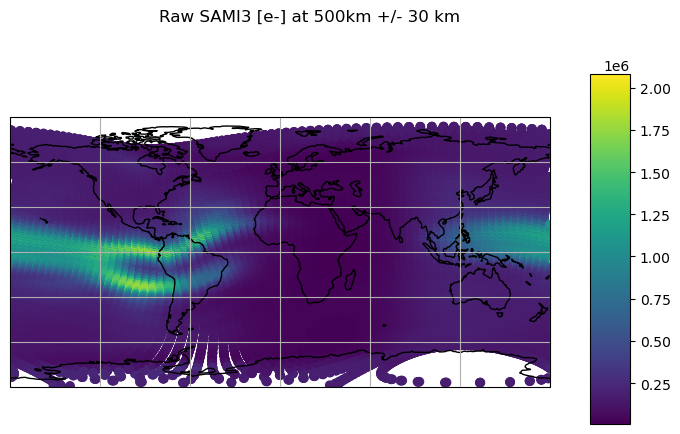

In [21]:
# PLOT A REFERENCE IMAGE:

min_alt = out_alt[alt_idx] - 30
max_alt = out_alt[alt_idx] + 30

single_alt_mask = np.where((samids.alt.values.flatten() > min_alt) 
                           & (samids.alt.values.flatten() < max_alt))

fig, ax = plt.subplots(1,1, figsize=(8,5), subplot_kw=dict(projection=ccrs.PlateCarree()))
im0 = ax.scatter(
      samids['glon'].values.flatten()[single_alt_mask], 
      samids['glat'].values.flatten()[single_alt_mask], 
      c=samids['edens'].isel(time=305).values.flatten()[single_alt_mask],
      transform=ccrs.PlateCarree())


ax.coastlines()
ax.gridlines()
ax.set_global()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im0, cax=cbar_ax)
fig.suptitle('Raw SAMI3 [e-] at 500km +/- 30 km')
fig.show();


/tmp/ipykernel_57746/776252490.py:15: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(im, cax=cbar_ax, label='[e-] ($\\frac{n}{cc}$) at %i km' %out_alts[alt_idx])
/tmp/ipykernel_57746/776252490.py:26: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(im2, cax=cbar_ax)


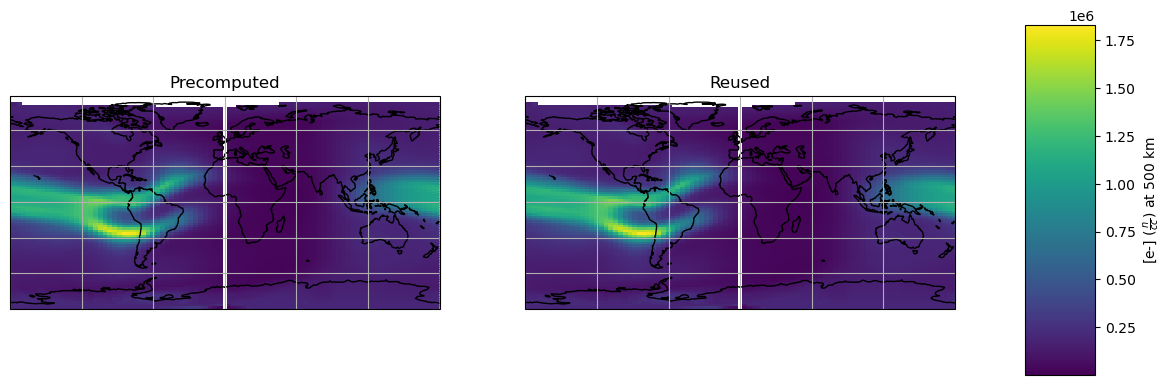

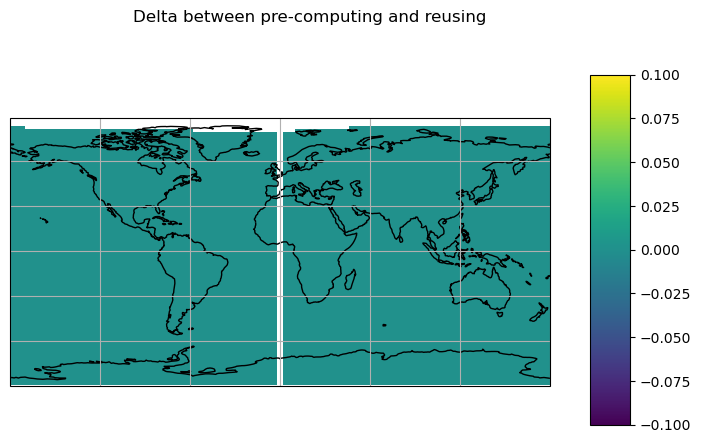

In [22]:
fig, axs = plt.subplots(1,2, width_ratios=(1,1),
                        figsize=(14,5), subplot_kw=dict(projection=ccrs.PlateCarree()))


axs[0].pcolor(out_lons, out_lats, out_vals[0,:,:,alt_idx])
axs[0].set_title('Precomputed')
im = axs[1].pcolor(out_lons, out_lats, out_vals2[0,:,:,alt_idx])
axs[1].set_title('Reused')
for ax in axs:
    ax.coastlines()
    ax.gridlines()
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='[e-] ($\\frac{n}{cc}$) at %i km' %out_alts[alt_idx])
fig.show();



fig, axs = plt.subplots(1,1, figsize=(8,5), subplot_kw=dict(projection=ccrs.PlateCarree()))
im2 = axs.pcolor(out_lons, out_lats, out_vals[0,:,:,alt_idx] - out_vals2[0,:,:,alt_idx])
axs.coastlines()
axs.gridlines()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax)
fig.suptitle('Delta between pre-computing and reusing')
fig.show();

So what is the problem with LinearNDInterpolator? It seems to be fast enough & the data looks good.

> The line at 0º longitude can be removed & shifted to 180º by adjusting the roll-over point in longitude, if desired.

There are a few reasons. Let's get into it!

### Problems with LinearNDInterpolator

1. It still isn't *that* fast. For 3 day SAMI3 run with outputs every 5 minutes, that would make ~850 output time steps. At ~5 seconds to interpolate each time step, that is ~4,200 seconds, or 70 minutes. Reasonable sure, but to interpolate all variables (SAMI outputs 15 densities, 4 temperatures, and 6 velocities), that's 25x70 = ***29 hours***. This can be multi-threaded but then we run into memory limitations. Sure, we don't need all that output data, but it is hard to predict what might be needed later, so it is nice to be able to just make it all.
1. It's not very accurate. I touched on this before, but will now show examples.
   1. In an ideal world, we can convert to cartesian coordinates (so the longitude is viewed as cyclic) and the gap disappears. But this adds to the interpolation errors.
   1. It seems that, no matter what kind of operations are done to the coordinates, interpolation errors show up along some axis. Let's take a look:


Here is a plot of the % difference between two timesteps, useful if one is looking for traveling features in the ionosphere:

/tmp/ipykernel_57746/603085349.py:10: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(im2, cax=cbar_ax, label="Percent Difference Between two Timesteps")


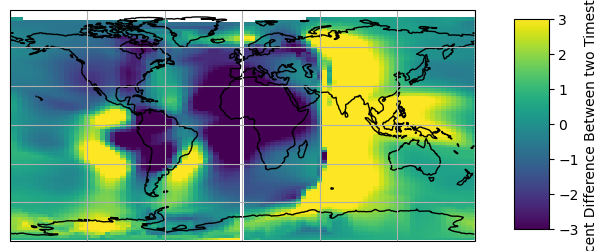

In [23]:
fig, axs = plt.subplots(1,1, figsize=(7,3), subplot_kw=dict(projection=ccrs.PlateCarree()))
im2 = axs.pcolor(out_lons, out_lats, 
                 100*((out_vals2[1,:,:,5] - out_vals2[0,:,:,5]) 
                      / out_vals2[1,:,:,5]), 
                 vmin=-3, vmax=3)
axs.coastlines()
axs.gridlines()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax, label="Percent Difference Between two Timesteps")

fig.show();

Looks normal!


Now if we plot a single geographic longitude (to see the altitude profile of a feature, for example):

TypeError: Dimensions of C (90, 20) are incompatible with X (90) and/or Y (20); see help(pcolor)

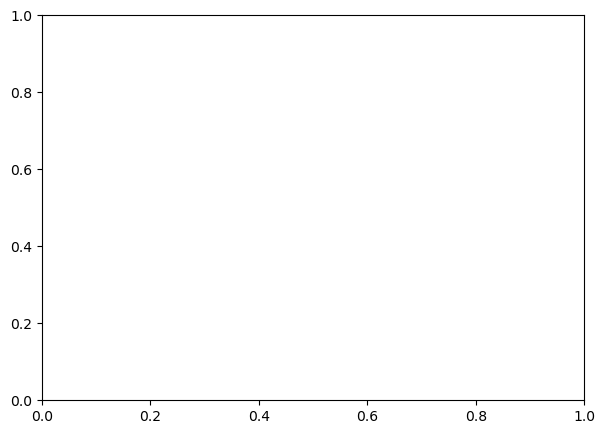

In [39]:
fig, axs = plt.subplots(1,1, figsize=(7,5))
im2 = axs.pcolor(out_lons, out_alts,
                 100*((out_vals2[1,5,:,:] - out_vals2[0,5,:,:]) 
                                       / out_vals2[1,5,:,:]), 
                 shading='gouraud',
                 cmap='jet')
# axs.coastlines()
# axs.gridlines()
axs.set_ylabel('Altitude (km)')
axs.set_xlabel('Geographic Latitude (deg)')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax, label='log10 [e-]')
# fig.suptitle('log10([e-]) at Geographic Longitude = ~20º')
fig.show();

Here is the raw data, for reference (taken within 2 degrees of longitude):

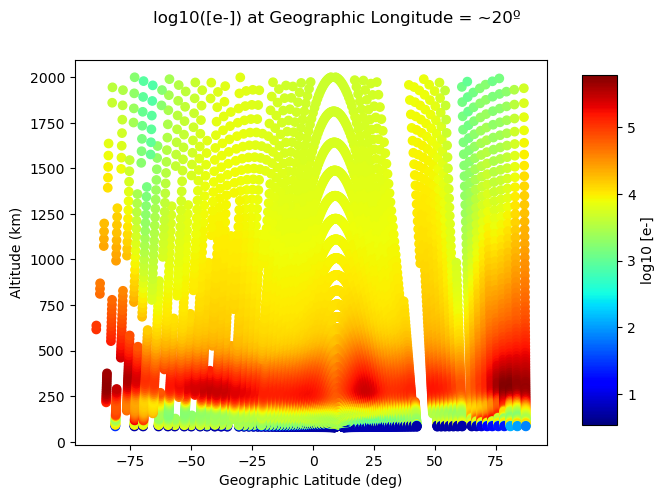

In [ ]:
at_glon_ma = np.where((sami_data['grid']['glon'] > 18) 
                      & (sami_data['grid']['glon'] < 22) 
                      & (sami_data['grid']['alt'] < 2000))

fig, axs = plt.subplots(1,1, figsize=(7,5))
im2 = axs.scatter(sami_data['grid']['glat'][at_glon_ma], 
                  sami_data['grid']['alt'][at_glon_ma], 
                  c=(sami_data['data']['edens'][:,:,:,305][at_glon_ma]), cmap='jet')
# axs.coastlines()
# axs.gridlines()
axs.set_ylabel('Altitude (km)')
axs.set_xlabel('Geographic Latitude (deg)')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax, label='log10 [e-]')
fig.suptitle('log10([e-]) at Geographic Longitude = ~20º')
fig.show();

Now if we narrow our mask from 2 to 1.5 degrees of longitude, one could maybe be convinced that the interpolation artifacts track fairly well with the distance from the cource grid... (It's sublte but I think that is causing the errors).

Source cells are in black & the background plot is the interpolated values:

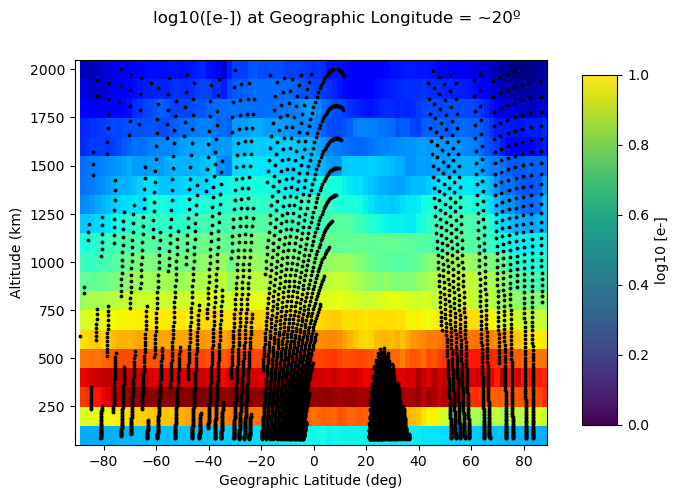

In [ ]:
at_glon_ma = np.where((sami_data['grid']['glon'] > 18.5) & (sami_data['grid']['glon'] < 21.5) & (sami_data['grid']['alt'] < 2000))

fig, axs = plt.subplots(1,1, figsize=(7,5))
im2 = axs.pcolor(out_lats, out_alts, np.log10(out_vals2[1,5,:,:].T), cmap='jet')
im2 = axs.scatter(sami_data['grid']['glat'][at_glon_ma], sami_data['grid']['alt'][at_glon_ma], 
                  c='k', s=3)
# axs.coastlines()
# axs.gridlines()
axs.set_ylabel('Altitude (km)')
axs.set_xlabel('Geographic Latitude (deg)')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax, label='log10 [e-]')
fig.suptitle('log10([e-]) at Geographic Longitude = ~20º')
fig.show();

This is only plotted at a coarse resolution to speed the notebook up. At higher resolutions (more altitude steps), the discontinuities get worse. Either trust me or try it yourself! 







We need something that is more accurate in the interpolations. And ideally faster...


## ESMF

As previously mentioned, ESMF is **HUGE**. We only care about a small portion of its capabilities.

An interested reader can explore [ESMF's documentation here](https://earthsystemmodeling.org/doc/), but I'll highlight the important bits here for those who value their time and sanity.


- ESMF has several representations of different types of model output.
  - The different grid structures are a "grid" (regtangular), "Mesh" (unstructured), and LocStream (unstructured, not connected). We want to use a "mesh"
  - Coordinate systems can be Cartesian or Spherical. We want 3D Spherical.
- We feed the output of SAMI3 into ESMF, specify the output locations, and ESMF tells us the "Weights" required to map between the coordinates
  - Due to the nature of the SAMI3 cell location, we need a "Mesh", and to tell ESMF how the points are connected in space.
     - In a Mesh, one must specify the interconnects between "Nodes", or grid cells.
     - For SAMI3, the "Nodes" are the individual grid cells.
     - The interconnects between the nodes are specified by the longitudes, field lines, and point (or more formally, (nl, nf, nz)). We tell ESMF which node indices are connected.
     - For the output grid, this can either be a grid in geographic coordinates (with fixed or stretched altitudes), or a set out unconnected points (satellite trajectory).
  - ESMF will then look at the source & destination "Fields" and figure out how much to multiply each source point by to get the interpolated value at each destination point.
  - These "Weights" are written to file & we later apply those weights to whatever we want.
   - Because of the source & destination types and the coordinate system, not all ESMF interpolation methods & versions will work. See the [ESMF regridding status](https://earthsystemmodeling.org/regrid/) page for more details.
- ESMF uses a "Bilinear" interpolation scheme to calculate the weight matrix. I have not noticed the same issues in these interpolations as those in LinearNDInterpolator.
- ESMF is complicated. To simplify things, I call ESMF from the command line within python ("Offline regridding") rather than using the C/Fortran/Python implementations. It's easier this way, trust me. 

For more details, see the ESMF documentation through either of the above links. 

For now, I will just jump in & demonstrate how it is implemented in this repository and explain what I can...



### The Details

As previously mentioned, SAMI3 needs to be represented as a "Mesh" in ESMF. The `esmpy` package is really hard to debug. So we will be writing the source and destination coordinates to NetCDF files and then calling ESMF from the "command line" (through python) on those files.

#### Node Information

To get ESMF to see our source points correctly, we need to specify the node coordinates & indices and the interconnects between these nodes. The rest is commentary, as they say.


From the [ESMF docs](https://earthsystemmodeling.org/docs/release/latest/ESMF_refdoc/node5.html#SECTION050101100000000000000), this is the representation for a hexahedron (cube/cuboid). We need to arrange SAMI3 points to be in this shape, with these interconnects between nodes.

              8---------------7
             /|              /|
            / |             / |
           /  |            /  |
          /   |           /   |
         5---------------6    |
         |    |          |    |
         |    4----------|----3
         |   /           |   /
         |  /            |  /
         | /             | /        
         |/              |/
         1---------------2

         ESMF_MESHELEMTYPE_HEX 

From the perspective of point 1 in the cube above I have arranged the mesh as follows:
- Point 4 lies on the same longitude & field line (*nl*, *nf*), but  *nz + 1*
- Points 2 & 3 lie on the next magnetic longitude (*nl + 1*), though same *nf*
- Point 5 has the same *nl* and *nz* as point 1, but *nf + 1*

Magnetic north will point from point 1 -> 4, east is from point 1 -> 2, and "up" is from point 1 -> 5.

The points on this cube look as follows:

| Point number  |  nl  |  nf  | nz  |
|  ---   |  --- | ---  | --- |
| 1 | `nl` | `nf` | `nz`|
| 2 | `nl+1` | `nf` | `nz`|
| 3 | `nl+1` | `nf+1` | `nz`|
| 4 | `nl` | `nf+1` | `nz`|
| 5 | `nl` | `nf` | `nz+1`|
| 6 | `nl+1` | `nf` | `nz+1`|
| 7 | `nl+1` | `nf+1` | `nz+1`|
| 8 | `nl` | `nf+1` | `nz+1`|

At high magnetic latitudes where SAMI3 does not model, the invalid points are not included. At the longitude boundary we wrap to form a complete sphere. At the ends of field lines (where `nz+1` does not exist), the invalid points are also not included.

> This methodology is how the source mesh is created. If the user requests to output to a grid, a similar methodology is followed. In the case that a user provides 

We tell ESMF the point locations & the connection that each node has with its neighbors.





#### Writing Source & Destination Files

In order for ESMF to read various files, NetCDF conventions are strictly enforced. There are only a handful of file formats that ESMF does understand. Of these, some do not support 3D unstructured meshes and others are just not right for this use case. So we write the source and destination grids to UGRID format.

[More details are available here], though the relevant NetCDF header is printed below (copied from that link). This is a sample header, though shows the important information.

```
netcdf wam_ugrid100_110 {
dimensions:
	nnodes = 78432 ;
	ncells = 66030 ;
	eight = 8 ;
variables:
	int mesh ;
		mesh:cf_role = "mesh_topology" ;
		mesh:topology_dimension = 3. ;
		mesh:node_coordinates = "nodelon nodelat height" ;
		mesh:volume_node_connectivity = "vertids" ;
		mesh:volume_shape_type = "meshtype" ;
	double nodelon(nnodes) ;
		nodelon:standard_name = "longitude" ;
		nodelon:units = "degrees_east" ;
	double nodelat(nnodes) ;
		nodelat:standard_name = "latitude" ;
		nodelat:units = "degrees_north" ;
	double height(nnodes) ;
		height:standard_name = "elevation" ;
		height:units = "kilometers" ;
	int vertids(ncells, eight) ;
		vertids:cf_role = "volume_node_connectivity" ;
		vertids:start_index = 1. ;
	int meshtype(ncells) ;
		meshtype:cf_role = "volume_shape_type" ;
		meshtype:flag_range = 1. ;
		meshtype:flag_values = 1. ;
		meshtype:flag_meanings = "hexahedron" ;
}
```


#### Applying Weights

After the weight generation is run, a file is created with the weight information. The relevant information is `n_s` (number of source points), `row` (position in destination grid of a point, `i`), `S` (weight for each entry in the regridding matrix), and `col` (position in the destination grid). 

The formula to apply the weights is as follows:

``` Fortran

 ! Initialize destination field to 0.0
 do i=1, n_b
   dst_field(i)=0.0
 enddo

 ! Apply weights
 do i=1, n_s
   dst_field(row(i))=dst_field(row(i))+S(i)*src_field(col(i))
 enddo

``` 

For loops are slow in Python. I have implemented something vctorized that accomplishes this. See the source code (`apply_weight_file()`) for more details.


[More information on the Weight file is in the ESMF documentation linked here.](https://earthsystemmodeling.org/docs/release/latest/ESMF_refdoc/node3.html#SECTION03029000000000000000)


## ESMF vs LinearNDInterpolator

Don't worry. I handled all of the hard stuff with ESMF. There are a collection of functions in the `SAMI3_ESMF_Regrid.py` file.

Let's see how ESMF speed and accuracy compares to LinearNDInterpolator (on the same data).



In [ ]:
import SAMI3_ESMF_Regrid

In [ ]:
import importlib

In [ ]:
SAMI3_ESMF_Regrid = importlib.reload(SAMI3_ESMF_Regrid)

In [ ]:
# Just like Delaunay, generating the weights takes a moment...

SAMI3_ESMF_Regrid.main(sami_path, pd.Timestamp('2013-03-16'), 
                       ESMF_DIR=os.path.expanduser('/home/axb170054/esmf-8.5.0/apps/appsO/Linux.intel.64.mvapich2.default/'),
                       do_apply_weights=False, cols=['edens'])


ESMF inputs already found. Will interpolate using the same input/output files.
 Run with remake_files=True to make the input/output files again.
calling ESMF...
Output:  Starting weight generation with these inputs: 
   Source File: /home/axb170054/example_sami_run/src_ugrid.nc
   Destination File: /home/axb170054/example_sami_run/dst_ugrid.nc
   Weight File: /home/axb170054/example_sami_run/esmf_weightfile.nc
   Source File is in UGRID format
   Source Grid is a global grid
   Source Grid is an unstructured grid
   Use the corner coordinates of the source grid to do the regrid
   Destination File is in UGRID format
   Destination Grid is a global grid
   Destination Grid is an unstructured grid
   Use the corner coordinates of the destination grid to do the regrid
   Regrid Method: bilinear
   Pole option: ALL
   Ignore unmapped destination points
   Line Type: greatcircle
   Norm Type: dstarea
   Extrap. Method: none
 
 Completed weight generation successfully.
 



<a name="cite_note-1"></a>1. [^](#cite_ref-1) Not sure why this is. If I had to guess, it would be because SAMI3 does not always convert from magnetic to geographic coordinates perfectly. There could also be floating point precision or rounding errors in Qhull/LinearNDInterpolator. 
